In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import torch
import torch.nn as nn
import torch.optim as optim

# Part 1a: Optimizing the Analytic Rosenbrock Function

In [2]:
def banana4(x):
    x = np.asarray(x)
    N = 4
    cost = 0.0
    for i in range(N - 1):
        cost += 100.0 * (x[i + 1] - x[i]**2)**2 + (1 - x[i])**2
    return cost


In [3]:
print("Global minimum:", banana4([1,1,1,1]))
print("Local minimum:", banana4([-1,1,1,1]))


Global minimum: 0.0
Local minimum: 4.0


## Optimization from the given initial condition

In [4]:
x0_given = np.array([-0.1565, 0.8315, 0.5844, 0.9190])

res_nm = minimize(banana4, x0_given, method="Nelder-Mead")
res_bfgs = minimize(banana4, x0_given, method="BFGS")

print("Given x0:", x0_given)
print("Nelder–Mead:", res_nm.x, res_nm.fun)
print("BFGS:", res_bfgs.x, res_bfgs.fun)


Given x0: [-0.1565  0.8315  0.5844  0.919 ]
Nelder–Mead: [0.99999249 0.99998742 0.99997651 0.99995496] 2.020926862073638e-09
BFGS: [-0.77565666  0.61308941  0.38205801  0.14596832] 3.701428610441304


## Optimization from a random initial condition

In [5]:
x0_rand = np.random.uniform(-1, 1, size=4)

res_nm_r = minimize(banana4, x0_rand, method="Nelder-Mead")
res_bfgs_r = minimize(banana4, x0_rand, method="BFGS")

print("Random x0:", x0_rand)
print("Nelder–Mead:", res_nm_r.x, res_nm_r.fun)
print("BFGS:", res_bfgs_r.x, res_bfgs_r.fun)


Random x0: [-0.87909444  0.54339434  0.51005988 -0.44646401]
Nelder–Mead: [-0.77521797  0.61238352  0.38121951  0.14531772] 3.7014290985684983
BFGS: [-0.77565674  0.61308951  0.38205812  0.14596839] 3.70142861044089


Observation: Gradient-based (BFGS) and non-gradient (Nelder–Mead) methods can converge to either the global or local minimum depending on initialization, even though the function is smooth and fully analytic.

# Part 1b: Optimizing Learned Functions

## Make dataset

In [13]:
important_points = np.array([
    [ 1.0, 1.0, 1.0, 1.0],   # global minimum
    [-1.0, 1.0, 1.0, 1.0]    # local minimum
])

def generate_dataset(
    N_uniform=8000,
    N_local=1000,
    bound=2.0,
    std=0.1
):
    # Uniform background samples
    X_uniform = np.random.uniform(-bound, bound, size=(N_uniform, 4))

    # Local samples around important points
    X_local = []
    for p in important_points:
        samples = np.random.normal(loc=p, scale=std, size=(N_local // len(important_points), 4))
        X_local.append(samples)

    X_local = np.vstack(X_local)

    # Combine
    X = np.vstack([X_uniform, X_local])

    # Evaluate function
    y = np.array([banana4(x) for x in X])

    return X, y

# --------------------------------------------
def generate_dataset_with_important_points(
    N_uniform=8000,
    N_local=2000,
    bound=2.0,
    std=0.1,
    seed=None
):
    """
    Generates training data that includes:
    - Uniform samples in [-bound, bound]^4
    - Local Gaussian samples around known important points

    Important points:
      (1, 1, 1, 1)   global minimum
      (-1, 1, 1, 1)  local minimum
    """

    if seed is not None:
        np.random.seed(seed)

    important_points = np.array([
        [ 1.0, 1.0, 1.0, 1.0],
        [-1.0, 1.0, 1.0, 1.0]
    ])

    # Uniform samples
    X_uniform = np.random.uniform(-bound, bound, size=(N_uniform, 4))

    # Local samples around important points
    samples_per_point = N_local // len(important_points)
    X_local = []

    for p in important_points:
        Xp = np.random.normal(loc=p, scale=std, size=(samples_per_point, 4))
        X_local.append(Xp)

    X_local = np.vstack(X_local)

    # Combine datasets
    X = np.vstack([X_uniform, X_local])

    # Evaluate true function
    y = np.array([banana4(x) for x in X])

    return X, y


X_train, y_train = generate_dataset(10000)
X_train, y_train = generate_dataset_with_important_points(
    N_uniform=8000,
    N_local=2000,
    std=0.1,
    seed=0
)


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)


x_test = torch.tensor([[-1,1,1,1],
                       [ 1,1,1,1]], dtype=torch.float32)
y_true = torch.tensor([4.0, 0.0])

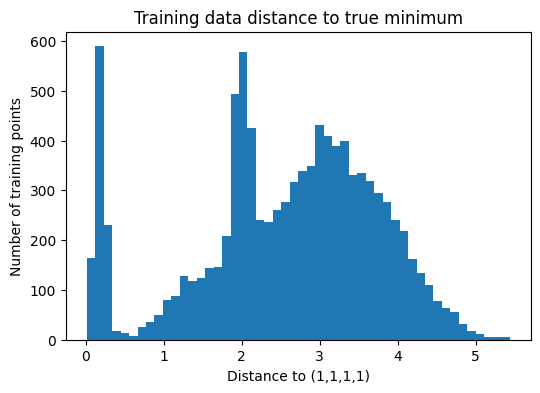

In [14]:

diffs = X_train - x_test[1, :]
dists = torch.norm(diffs, dim=1)

plt.figure(figsize=(6,4))
plt.hist(dists, bins=50)
plt.xlabel("Distance to (1,1,1,1)")
plt.ylabel("Number of training points")
plt.title("Training data distance to true minimum")
plt.show()


## Define Model & Train

In [15]:
net = nn.Sequential(
    nn.Linear(4, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1)
)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [ ]:
training_steps = 50000
for step in range(training_steps):
    optimizer.zero_grad()
    loss = loss_fn(net(X_train), y_train)
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f"Step {step}, loss = {loss.item():.6f}")


Step 0, loss = 2632029.750000
Step 1000, loss = 2470631.750000
Step 2000, loss = 2341369.500000
Step 3000, loss = 2222799.750000
Step 4000, loss = 2113310.250000
Step 5000, loss = 2012207.250000
Step 6000, loss = 1919141.250000
Step 7000, loss = 1833918.875000
Step 8000, loss = 1700690.250000
Step 9000, loss = 1605531.000000
Step 10000, loss = 1519954.250000
Step 11000, loss = 1440171.000000
Step 12000, loss = 1365254.625000
Step 13000, loss = 1294716.375000
Step 14000, loss = 1228321.750000
Step 15000, loss = 1160902.500000
Step 16000, loss = 1079818.375000
Step 17000, loss = 1010185.437500
Step 18000, loss = 948847.500000
Step 19000, loss = 893747.312500
Step 20000, loss = 841835.875000
Step 21000, loss = 792777.750000
Step 22000, loss = 746376.375000
Step 23000, loss = 702485.687500
Step 24000, loss = 660966.812500
Step 25000, loss = 621692.000000
Step 26000, loss = 584567.375000
Step 27000, loss = 549455.750000
Step 28000, loss = 516279.281250
Step 29000, loss = 484963.593750
Step 

In [12]:


with torch.no_grad():
    y_pred = net(x_test).squeeze()

print("Predicted:", y_pred)
print("True:", y_true)
print("Absolute error:", torch.abs(y_pred - y_true))


Predicted: tensor([881.2829, 881.2829])
True: tensor([4., 0.])
Absolute error: tensor([877.2829, 881.2829])


What to turn in: 

The writeup is what matters for this section. 
## 1. What I want you to write up is all the things that go wrong and go right with trying to optimize learned functions. 

### What goes wrong when optimizing learned functions

- Learned model predicts wrong values near the true minima 
- Outside the training data distribution, the learned model extrapolates unpredictably, leading to unreliable optimization results.

### What goes right?

- Learned models are fast to evaluate once trained.

- At or near training points, the learned model behaves more reliably.

- With more training data, especially near the optimum, the learned model can generalize better and improve optimization performance

## 2. What is different from optimizing analytic functions? 

- Analytic functions are known exactly and are correct everywhere in the domain.

- Gradients of analytic functions can be computed exactly, leading to reliable optimization.

- Learned functions are approximate and only accurate where data exists.

- Gradients of learned functions may be incorrect, even when function values appear reasonable.

3. What is your advice for folks using machine learning to optimize robot performance on various tasks where we don't have analytic functions that score task performance? (generalization is important. Diverse data is needed)

- Constrain optimization to regions covered by the training data.
- Do not blindly trust learned gradients without validation.
- Use diverse training data to improve generalization.



Extra

1. Assuming you can fit this function well, how about taking derivatives?
2. Do the analytic derivatives of your approximate function match the analytic derivatives of the true function as well as the match to the function values? 
3. What is the summed error of the learned derivatives across all the training points? 
